# **Mounting Google Drive and Installing Dependencies**

In [48]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
DATA_DIR = '/content/drive/MyDrive/'
image_dir = os.path.join(DATA_DIR, 'images')
mask_dir = os.path.join(DATA_DIR, 'labels')

# **Installing Dependencies**

In [50]:
# !pip install torch torchvision transformers segmentation-models-pytorch albumentations


# **Importing Libraries**

In [51]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt

# **Creating Custom Dataset**

In [52]:
# --- Custom Dataset --- #

class RockCarvingDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.images = [f for f in os.listdir(images_dir) if os.path.exists(os.path.join(masks_dir, f))]
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.images[idx])
        mask_path = os.path.join(self.masks_dir, self.images[idx])

        image = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if image is None:
            raise FileNotFoundError(f"Image not found or unreadable: {img_path}")
        if mask is None:
            raise FileNotFoundError(f"Mask not found or unreadable: {mask_path}")

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.resize(mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)
        mask = (mask > 127).astype(np.float32)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask.unsqueeze(0)

transform = A.Compose([
    A.Resize(512, 512),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2()
])

full_dataset = RockCarvingDataset(image_dir, mask_dir, transform=transform)
train_size = int(0.8 * len(full_dataset)) # Training on 80% of the data
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

# --- Creating dataloaders --- #
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)

# **Loading Pretrained Unet with Segformer Backbone**

In [53]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = smp.Unet(
    encoder_name='mit_b0',
    encoder_weights='imagenet',
    in_channels=3,
    classes=1,
).to(device)

loss_fn = smp.losses.DiceLoss(mode='binary')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

def iou_score(preds, targets, threshold=0.5):
    preds = (preds > threshold).float()
    intersection = (preds * targets).sum()
    union = preds.sum() + targets.sum() - intersection + 1e-7
    return (intersection / union).item()

def dice_score(preds, targets, threshold=0.5):
    preds = (preds > threshold).float()
    intersection = (preds * targets).sum()
    return (2. * intersection + 1e-7) / (preds.sum() + targets.sum() + 1e-7)

# **Training the Model**

In [54]:
# --- Tracking the losses and training the model --- #
train_losses = []
val_losses = []
ious = []
dices = []
combineds = []

epochs = 15
for epoch in range(epochs):
    model.train()
    train_loss = 0.0

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0.0
    val_iou = 0.0
    val_dice = 0.0

    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, masks)
            val_loss += loss.item()

            probs = torch.sigmoid(outputs)
            val_iou += iou_score(probs, masks)
            val_dice += dice_score(probs, masks).item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    avg_iou = val_iou / len(val_loader)
    avg_dice = val_dice / len(val_loader)
    combined = (avg_iou + avg_dice) / 2

    # Store metrics
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    ious.append(avg_iou)
    dices.append(avg_dice)
    combineds.append(combined)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | "
          f"IoU: {avg_iou:.4f} | "
          f"Dice: {avg_dice:.4f} | "
          f"Combined: {combined:.4f}")

Epoch 1/15 | Train Loss: 0.6294 | Val Loss: 0.5326 | IoU: 0.3839 | Dice: 0.5532 | Combined: 0.4685
Epoch 2/15 | Train Loss: 0.5106 | Val Loss: 0.4514 | IoU: 0.5395 | Dice: 0.6997 | Combined: 0.6196
Epoch 3/15 | Train Loss: 0.4355 | Val Loss: 0.3981 | IoU: 0.6086 | Dice: 0.7554 | Combined: 0.6820
Epoch 4/15 | Train Loss: 0.3878 | Val Loss: 0.3380 | IoU: 0.6986 | Dice: 0.8217 | Combined: 0.7602
Epoch 5/15 | Train Loss: 0.3383 | Val Loss: 0.3020 | IoU: 0.7154 | Dice: 0.8333 | Combined: 0.7743
Epoch 6/15 | Train Loss: 0.3018 | Val Loss: 0.2915 | IoU: 0.6878 | Dice: 0.8141 | Combined: 0.7510
Epoch 7/15 | Train Loss: 0.2775 | Val Loss: 0.2548 | IoU: 0.7250 | Dice: 0.8394 | Combined: 0.7822
Epoch 8/15 | Train Loss: 0.2487 | Val Loss: 0.2546 | IoU: 0.7035 | Dice: 0.8251 | Combined: 0.7643
Epoch 9/15 | Train Loss: 0.2287 | Val Loss: 0.2243 | IoU: 0.7176 | Dice: 0.8346 | Combined: 0.7761
Epoch 10/15 | Train Loss: 0.2099 | Val Loss: 0.2317 | IoU: 0.7091 | Dice: 0.8292 | Combined: 0.7692
Epoch 11/

# **Plotting Losses**

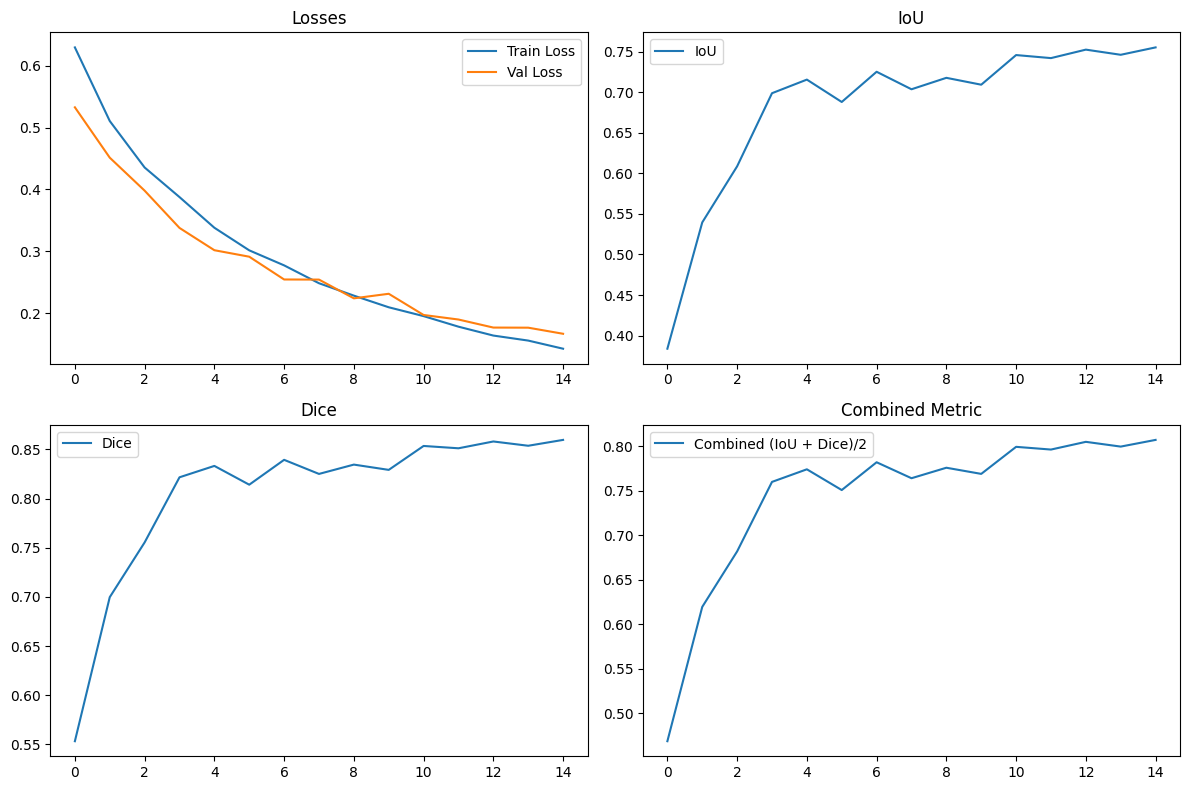

In [55]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Losses')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(ious, label='IoU')
plt.title('IoU')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(dices, label='Dice')
plt.title('Dice')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(combineds, label='Combined (IoU + Dice)/2')
plt.title('Combined Metric')
plt.legend()

plt.tight_layout()
plt.show()

# **Visualizing Predictions**

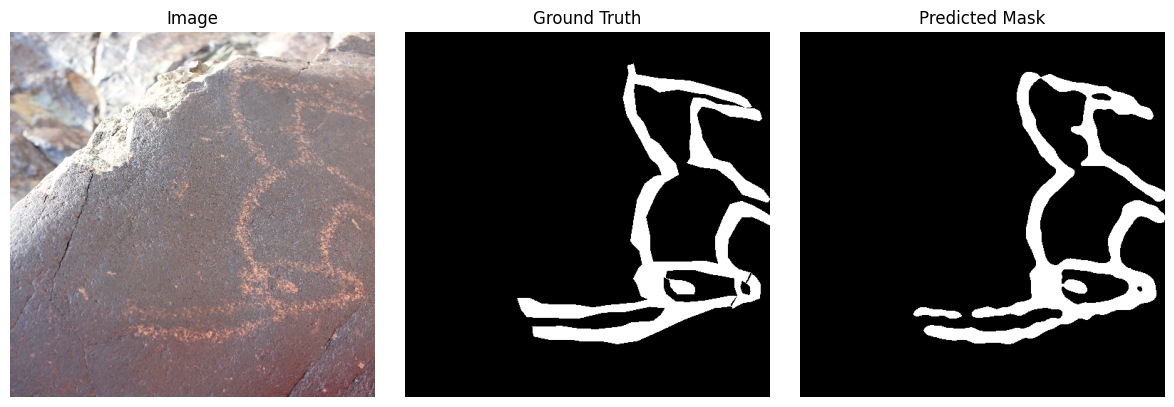

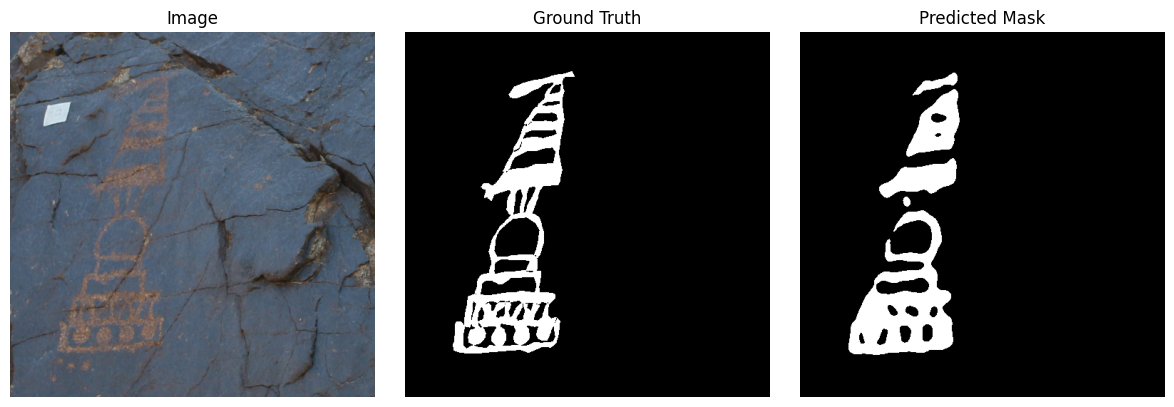

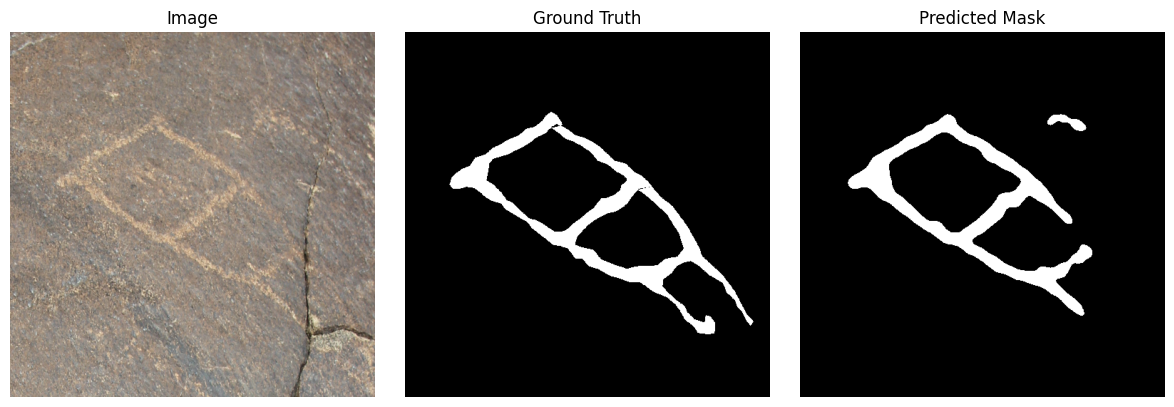

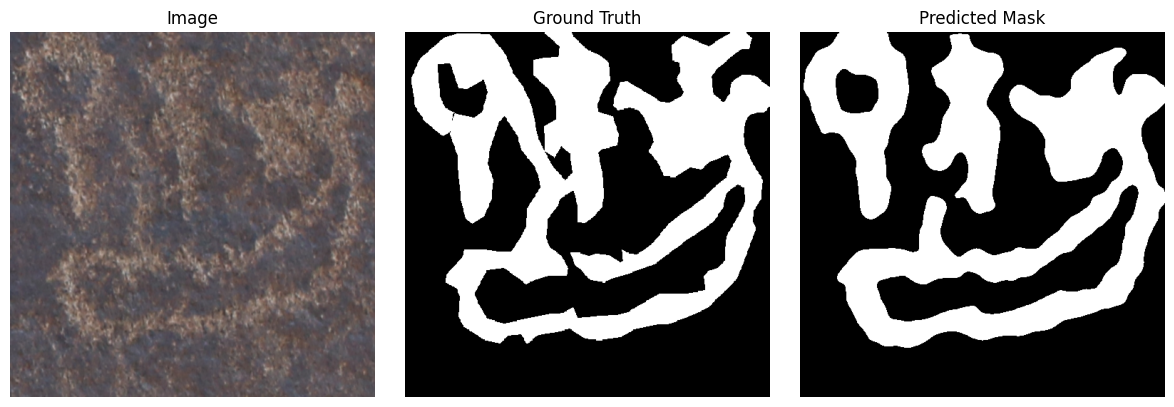

In [57]:
def denormalize(image, mean, std):
    image = image * std + mean
    image = np.clip(image, 0, 1)
    return image

def visualize_prediction(image, mask, pred_mask, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)):
    image = image.permute(1, 2, 0).cpu().numpy()
    image = denormalize(image, mean, std)

    mask = mask.squeeze().cpu().numpy()
    pred_mask = pred_mask.squeeze().cpu().numpy()

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(image)
    axs[0].set_title("Image")
    axs[1].imshow(mask, cmap='gray')
    axs[1].set_title("Ground Truth")
    axs[2].imshow(pred_mask > 0.5, cmap='gray')
    axs[2].set_title("Predicted Mask")

    for ax in axs: ax.axis("off")
    plt.tight_layout()
    plt.show()

model.eval()

with torch.no_grad():
    for images, masks in val_loader:
        images = images.to(device)
        masks = masks.to(device)
        outputs = model(images)
        preds = torch.sigmoid(outputs)

        for i in range(min(5, images.shape[0])):
            visualize_prediction(images[i], masks[i], preds[i])
        break
